# Import libraries

In [1]:
%matplotlib inline
from matplotlib import style
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, Date, desc

In [5]:
# Create engine using the `hawaii.sqlite` database file

engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [8]:
# Save object references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Climate Analysis

In [10]:
# Inspect database table to get columns and data types

inspector = inspect(engine)

inspector.get_table_names()

# Get a list of column names and types

columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])

    # columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Display the row's columns and data in dictionary format

first_row_Measurement = session.query(Measurement).first()
first_row_Measurement.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26ef5269b70>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
# Find last date in database

Last_Date = session.query(func.max(Measurement.date)).all()

Last_Date


[('2017-08-23')]

In [13]:
# Last Date of observation all the way back through 12 months

Last_Year_Observation = dt.date(2017, 8, 23) - dt.timedelta(days=7*52)

Last_Year_Observation

datetime.date(2016, 8, 24)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > Last_Year_Observation).all()


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(results)

df.columns =  results[0].keys()

df.set_index('date',inplace = True)

# Sort the dataframe by date

df_sorted = df.sort_values('date')

df_sorted.head(10)

,prcp
date,
2016-08-25,0.08
2016-08-25,0.00
2016-08-25,0.06
2016-08-25,0.00
2016-08-25,0.08
2016-08-25,0.11
2016-08-25,0.21
2016-08-26,0.00
2016-08-26,0.00


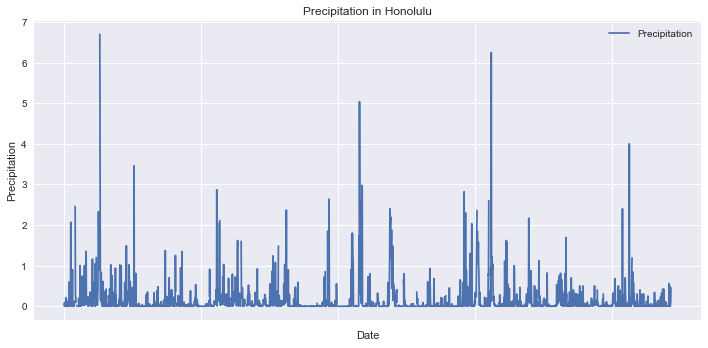

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

sns.set()

plot1 = df_sorted.plot(figsize = (10, 5))

fig = plot1.get_figure()

plt.title('Precipitation in Honolulu')

plt.xlabel('Date')

plt.ylabel('Precipitation')

plt.legend(["Precipitation"],loc="best")

plt.xticks(rotation=45)

plt.tight_layout()

fig.savefig("../Images/Precipitation_Analysis.png")

plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data

Summary_Stats_DF = df_sorted.describe()

Summary_Stats_DF.rename(columns = {'prcp' : 'Precipitation'})

,Precipitation
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [18]:
# Display the row's columns and data in dictionary format

first_row_Station = session.query(Station).first()
first_row_Station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26ef74422e8>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

In [19]:
# Setting the dataframe for Station 

results_station = session.query(Station.latitude,Station.longitude,Station.id,Station.elevation,Station.station,Station.name).all()

df_stations = pd.DataFrame(results_station)

df_stations.head()

,latitude,longitude,id,elevation,station,name
0,21.2716,-157.8168,1,3.0,USC00519397,"WAIKIKI 717.2, HI US"
1,21.4234,-157.8015,2,14.6,USC00513117,"KANEOHE 838.1, HI US"
2,21.5213,-157.8374,3,7.0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,21.3934,-157.9751,4,11.9,USC00517948,"PEARL CITY, HI US"
4,21.4992,-158.0111,5,306.6,USC00518838,"UPPER WAHIAWA 874.3, HI US"


In [20]:
# How many stations are available in this dataset - through SQL Alchemy

Number_of_Stations = session.query(Station.station).count()
 
print(f"Available Station(s): {Number_of_Stations}")

Available Station(s): 9


In [21]:
# What are the most active stations?

Active_Stations = session.query(Station.station,func.count(Measurement.tobs)).filter(Station.station == Measurement.station).\
                  group_by(Station.station).order_by(desc(func.count(Measurement.tobs))).all()

# List the stations and the counts in descending order.

print(f"{Active_Stations[0][0]} has {Active_Stations[0][1]} observations!")

Active_Stations


USC00519281 has 2772 observations!


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

Station_Name = session.query(Station.name).filter(Station.station == Active_Stations[0][0]).all() 

print(Station_Name)

Temp_Stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
             filter(Station.station == Active_Stations[0][0]).all()

print(Temp_Stats)

[('WAIHEE 837.5, HI US',)]
[(53.0, 87.0, 73.09795396419437)]


In [23]:
# Choose the station with the highest number of temperature observations.

Station_Name = session.query(Station.name).filter(Station.station == Active_Stations[0][0]).all() 

print(Station_Name)


[('WAIHEE 837.5, HI US',)]


In [24]:
# Query the last 12 months of temperature observation data for this station 

results_WAIHEE = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date > Last_Year_Observation).\
                            filter(Station.station == Active_Stations[0][0]).all()

results_WAIHEE_df = pd.DataFrame(results_WAIHEE)

results_WAIHEE_df.head()

,date,tobs
0,2016-08-25,80.0
1,2016-08-26,79.0
2,2016-08-27,77.0
3,2016-08-28,78.0
4,2016-08-29,78.0


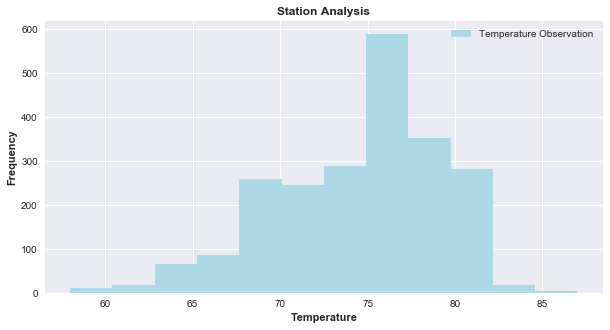

In [25]:
# Plot the results as a histogram

sns.set()

plt.figure(figsize=(10,5))

plt.hist(results_WAIHEE_df['tobs'],bins=12,color='lightblue')

plt.xlabel('Temperature',weight='bold')

plt.ylabel('Frequency',weight='bold')

plt.title('Station Analysis',weight='bold')

plt.legend(["Temperature Observation"],loc="best")

plt.savefig("../Images/Temperature_Analysis.png")

plt.show()